<a href="https://colab.research.google.com/github/nick125015/1213132123/blob/main/S0922128_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **使用的是鳥的圖片**

In [ ]:


!pip install torch torchvision matplotlib numpy pandas
!mkdir -p content/quickdraw_data
!curl -o content/quickdraw_data/bird.npy https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# 資料輸入輸出所需套件：
import numpy as np
import os
import pandas as pd

# 深度學習所需套件：
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, datasets
from torchsummary import summary

# 繪圖所需套件：
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

#### 載入資料集

In [ ]:
data_dir='./content/quickdraw_data'  #請記得依你存放的位置彈性修改路徑
input_images = data_dir + "/bird.npy"

In [ ]:
data = np.load(input_images)

In [ ]:
data.shape

(133572, 784)

In [ ]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  13,  67,  94,  74,   7,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  71, 237, 255, 255, 255, 219,
        30,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  36, 245, 201,  62,  30,
        68, 236, 204,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 106, 255,  26,
         0,   0,   0,  67, 251, 173,  36,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 154,
       227,   0,   0,   0,   0,  18, 180, 255, 255, 103,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape


(133572, 28, 28, 1)

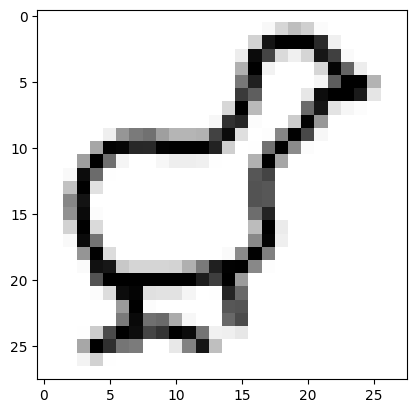

In [ ]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

In [ ]:
# 轉換成pytorch的資料格式
data = data.astype(np.float32)  # 將資料類型轉換成float32

data = data.reshape(-1, 1, 28, 28)  # 將資料大小重新Resize到四維的28*28 [N(batchsize), Channels, Height, Width]

# 将numpy轉換成torch張量
data_tensor = torch.tensor(data)

# 建立假的標註資料，因為 GAN 訓練中標籤通常在訓練的過程中會自己生成
labels = torch.zeros(data_tensor.size(0), dtype=torch.float32)

# 建立TensorDataset和DataLoader
dataset = TensorDataset(data_tensor, labels)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

#### 建構鑑別器 (discriminator) 神經網路

##### 這個鑑別器有三層卷積層
    卷積層的深度(feature map depth為64)，所以在第一層隱藏層有64個特徵，接著逐層倍增
    選用Sigmoid原因為辨別器的任務皆為二元分類，因此輸出層只需要一個神經元[連結文字](https://)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, depth=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(

            nn.Conv2d(1, depth, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(depth),
            nn.LeakyReLU(0.2),

            nn.Conv2d(depth, depth * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(depth * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(depth * 2, depth * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(depth * 4),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(depth * 4 * 4 * 4, 1),
            nn.Sigmoid()

        )

    def forward(self, img):
        validity = self.model(img)
        return validity


#### 建構生成器 (generator) 神經網路

##### 使用 nn.Upsample 來增大特徵圖的尺寸，然後接一般的卷積層 nn.Conv2d 來處理這些放大後的特徵圖
    latent_dim=100: 輸入向量的維度，即隱藏空間的大小
    使用上採樣(Upsample)和標準卷積層的組合來生成所需尺寸的圖像
    實現從緊湊的隱藏特徵映射到更大空間尺寸的圖像，但與反卷積層相比，使用上採樣和標準卷積層的組合通常能更好地控制生成圖像的質量，避免典型的反卷積層可能帶來的棋盤效應（checkerboard artifacts）

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, depth=64, init_size=7): #可以調
        super(Generator, self).__init__()
        self.init_size = init_size
        self.l1 = nn.Sequential(nn.Linear(latent_dim, depth * init_size ** 2))
        self.conv_blocks = nn.Sequential(

            nn.BatchNorm2d(depth),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(depth, depth // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(depth // 2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(depth // 2, depth // 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(depth // 4),
            nn.ReLU(),
            nn.Conv2d(depth // 4, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()


        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 64, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

#### 定義 train() 函式並進行 GAN 的訓練

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 建立模型
latent_dim = 100
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

# 優化器設定
lr = 0.001
b1 = 0.5
b2 = 0.999
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))

# 損失函數
criterion = nn.BCELoss()

summary(G, input_size=(latent_dim,))
summary(D, input_size=(1, 28, 28))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         316,736
       BatchNorm2d-2             [-1, 64, 7, 7]             128
              ReLU-3             [-1, 64, 7, 7]               0
          Upsample-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]          18,464
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
          Upsample-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           4,624
      BatchNorm2d-10           [-1, 16, 28, 28]              32
             ReLU-11           [-1, 16, 28, 28]               0
           Conv2d-12            [-1, 1, 28, 28]             145
          Sigmoid-13            [-1, 1, 28, 28]               0
Total params: 340,193
Trainable params:

In [ ]:
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         LeakyReLU-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]          73,856
       BatchNorm2d-5            [-1, 128, 7, 7]             256
         LeakyReLU-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
       BatchNorm2d-8            [-1, 256, 4, 4]             512
         LeakyReLU-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                    [-1, 1]           4,097
          Sigmoid-12                    [-1, 1]               0
Total params: 374,657
Trainable params: 374,657
Non-trainable params: 0
-------------------------------

Epoch 1, D Loss: 0.536324222365178, G Loss: 3.250313344528173, D Accuracy: 0.91
Epoch 2, D Loss: 0.3442973838214054, G Loss: 3.83222283276403, D Accuracy: 0.95
Epoch 3, D Loss: 0.25812713497115036, G Loss: 4.255267026310668, D Accuracy: 0.96
Epoch 4, D Loss: 0.16250304791612152, G Loss: 4.927838855424121, D Accuracy: 0.98
Epoch 5, D Loss: 0.21347602535501822, G Loss: 4.996283204494627, D Accuracy: 0.97
Epoch 6, D Loss: 0.1287779243424719, G Loss: 5.451174498702111, D Accuracy: 0.98
Epoch 7, D Loss: 0.20675385994872666, G Loss: 5.865125672285245, D Accuracy: 0.98
Epoch 8, D Loss: 0.12271183027303767, G Loss: 6.061896549531602, D Accuracy: 0.99
Epoch 9, D Loss: 0.11820690752038945, G Loss: 6.039272557949079, D Accuracy: 0.98
Epoch 10, D Loss: 0.16922108024954252, G Loss: 6.009162992112136, D Accuracy: 0.98


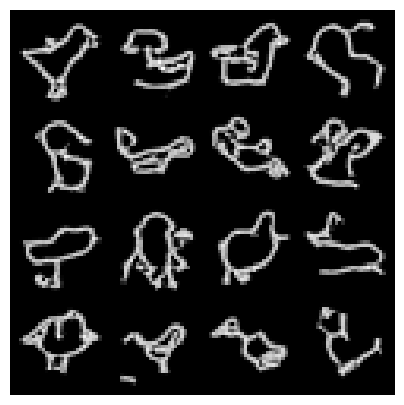

Epoch 11, D Loss: 0.09440842625783125, G Loss: 6.659440736406966, D Accuracy: 0.99
Epoch 12, D Loss: 0.06403960602840923, G Loss: 6.9023393863914775, D Accuracy: 0.99
Epoch 13, D Loss: 0.07270058702392845, G Loss: 6.694861533444186, D Accuracy: 0.99
Epoch 14, D Loss: 0.03956324206156588, G Loss: 7.408349340303734, D Accuracy: 0.99
Epoch 15, D Loss: 0.11493433403178148, G Loss: 6.2512928271250106, D Accuracy: 0.98
Epoch 16, D Loss: 0.08162107991570378, G Loss: 6.987054674042914, D Accuracy: 0.99
Epoch 17, D Loss: 0.10086511078257411, G Loss: 7.285037119773705, D Accuracy: 0.99
Epoch 18, D Loss: 0.043727590595391407, G Loss: 7.411063757871063, D Accuracy: 0.99
Epoch 19, D Loss: 0.07328294758846123, G Loss: 7.075286447008094, D Accuracy: 0.99
Epoch 20, D Loss: 0.07754753610479057, G Loss: 7.064637274825376, D Accuracy: 0.99


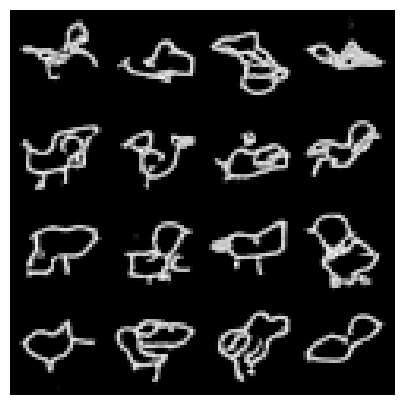

Epoch 21, D Loss: 0.07656525911966515, G Loss: 7.626916653612602, D Accuracy: 0.99
Epoch 22, D Loss: 0.05532341437166125, G Loss: 7.609408095677113, D Accuracy: 0.99
Epoch 23, D Loss: 0.09041370987500495, G Loss: 6.9793739553773095, D Accuracy: 0.99
Epoch 24, D Loss: 0.07762210640395563, G Loss: 7.437351812048399, D Accuracy: 0.99
Epoch 25, D Loss: 0.06415344395090154, G Loss: 8.171327905524535, D Accuracy: 0.99
Epoch 26, D Loss: 0.6920094211264202, G Loss: 7.592628055207851, D Accuracy: 0.99
Epoch 27, D Loss: 0.03880495335966149, G Loss: 7.46843679940194, D Accuracy: 1.00
Epoch 28, D Loss: 0.12557170429590986, G Loss: 6.9790636997537145, D Accuracy: 0.99
Epoch 29, D Loss: 0.06200035839667528, G Loss: 7.535362415728113, D Accuracy: 0.99
Epoch 30, D Loss: 0.010406754628886346, G Loss: 8.076493525126887, D Accuracy: 1.00


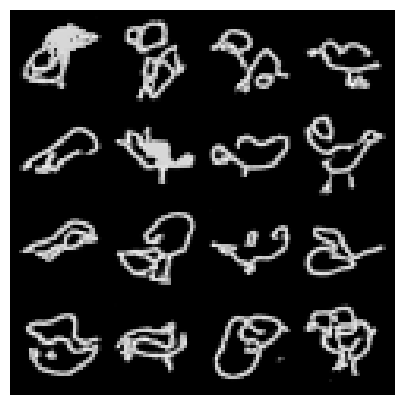

Epoch 31, D Loss: 0.11650393423668123, G Loss: 6.815600234450554, D Accuracy: 0.98
Epoch 32, D Loss: 17.546690123927263, G Loss: 6.973802342682027, D Accuracy: 0.91
Epoch 33, D Loss: 100.0, G Loss: 0.0, D Accuracy: 0.50
Saving model with D accuracy: 0.50...


In [ ]:
best_model_path = 'best_model_0.5_acc.ckpt'

epochs = 50
for epoch in range(epochs):
    D_running_loss = 0.0
    G_running_loss = 0.0
    D_correct = 0
    D_total = 0

    for real_images, _ in data_loader:
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train with real images
        D_real = D(real_images)
        D_real_loss = criterion(D_real, real_labels)
        real_predictions = D_real > 0.5
        D_correct += real_predictions.sum().item()
        D_total += batch_size

        # Train with fake images
        fake_images = G(torch.randn(batch_size, latent_dim, device=device))
        D_fake = D(fake_images)
        D_fake_loss = criterion(D_fake, fake_labels)
        fake_predictions = D_fake < 0.5
        D_correct += fake_predictions.sum().item()

        D_loss = D_real_loss + D_fake_loss
        D_running_loss += D_loss.item() * batch_size

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train Generator
        fake_images = G(torch.randn(batch_size, latent_dim, device=device))
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, real_labels)
        G_running_loss += G_loss.item() * batch_size

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

    D_epoch_loss = D_running_loss / D_total
    G_epoch_loss = G_running_loss / D_total
    D_accuracy = D_correct / (2 * D_total)  # 因為真假圖像各占一半

    print(f"Epoch {epoch+1}, D Loss: {D_epoch_loss}, G Loss: {G_epoch_loss}, D Accuracy: {D_accuracy:.2f}")


    # 儲存最好的模型
    if D_accuracy <= 0.5:
        print(f"Saving model with D accuracy: {D_accuracy:.2f}...")
        torch.save(D.state_dict(), best_model_path)
        break

    if (epoch + 1) % 10 == 0:
        # Generate and display images
        with torch.no_grad():
            test_noise = torch.randn(16, latent_dim, device=device)
            generated_images = G(test_noise)
            generated_images = generated_images.detach().cpu()
            grid = make_grid(generated_images, nrow=4, normalize=True)
            plt.figure(figsize=(5, 5))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.show()